# Optimization Example

This notebook demonstrates how to use the `seapopym-optimization` package to estimate biological parameters for the `NoTransportModel`.

We will:

1.  **Generate synthetic data**: Create forcing fields (temperature, primary production) and run the model with "known" parameters to create a ground truth.
2.  **Create pseudo-observations**: Add noise to the ground truth to simulate real data.
3.  **Configure the Optimization**: Define a cost function and which parameters to optimize.
4.  **Run the Genetic Algorithm**: Find the parameters that best fit the observations.
5.  **Analyze Results**: Visualize the convergence and the final fit.


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from seapopym.configuration.no_transport import ForcingParameter, ForcingUnit
from seapopym.model import NoTransportModel
from seapopym_optimization.algorithm.genetic_algorithm.factory import GeneticAlgorithmFactory
from seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm import GeneticAlgorithmParameters
from seapopym_optimization.algorithm.genetic_algorithm.logbook import LogbookCategory, LogbookIndex
from seapopym_optimization.configuration_generator.no_transport_configuration_generator import (
    NoTransportConfigurationGenerator,
)
from seapopym_optimization.cost_function.cost_function import CostFunction
from seapopym_optimization.cost_function.metric import rmse_comparator
from seapopym_optimization.cost_function.processor import TimeSeriesScoreProcessor
from seapopym_optimization.functional_group import FunctionalGroupSet, NoTransportFunctionalGroup, Parameter
from seapopym_optimization.functional_group.parameter_initialization import random_uniform_exclusive
from seapopym_optimization.observations.observation import DayCycle
from seapopym_optimization.observations.time_serie import TimeSeriesObservation

## 1. Synthetic Data Generation

We create synthetic temperature and primary production fields. SeapoPym requires specific `ForcingParameter` objects.


In [11]:
nb_days_by_year = 365
nb_years = 5
total_days = nb_days_by_year * nb_years

time_index = pd.date_range("2020-01-01", periods=total_days, freq="D")

# Temperature: sinusoidal pattern
temp_data = (np.sin(np.linspace(0, (2 * np.pi) * nb_years, total_days)) * 5 + 20).reshape((total_days, 1, 1, 1))
temperature = xr.DataArray(
    data=temp_data,
    dims=["time", "latitude", "longitude", "depth"],
    coords={
        "time": time_index,
        "latitude": [0],
        "longitude": [0],
        "depth": [0],
    },
    name="temperature",
    attrs={"units": "Celsius", "long_name": "Sea surface temperature", "standard_name": "sea_surface_temperature"},
)

# Primary production: random + cosine pattern
pp_data = (
    np.random.rand(total_days).reshape((total_days, 1, 1))
    + np.cos(np.linspace(0, np.pi * nb_years, total_days)).reshape((total_days, 1, 1))
    + 2
) / 100
primary_production = xr.DataArray(
    data=pp_data,
    dims=["time", "latitude", "longitude"],
    coords={
        "time": time_index,
        "latitude": [0],
        "longitude": [0],
    },
    name="primary_production",
    attrs={"units": "kg/m^2/day", "long_name": "Primary production", "standard_name": "primary_production"},
)

# Set axis attributes (critical for SeapoPym)
temperature.time.attrs = {"axis": "T"}
primary_production.time.attrs = {"axis": "T"}
temperature.latitude.attrs = {"axis": "Y"}
primary_production.latitude.attrs = {"axis": "Y"}
temperature.longitude.attrs = {"axis": "X", "unit": "degrees_east"}
primary_production.longitude.attrs = {"axis": "X"}
temperature.depth.attrs = {"axis": "Z"}

# Create ForcingParameter
forcing_param = ForcingParameter(
    temperature=ForcingUnit(forcing=temperature),
    primary_production=ForcingUnit(forcing=primary_production),
)

primary_production unit is kilogram / day / meter ** 2, it will be converted to gram / day / meter ** 2.
primary_production unit is kilogram / day / meter ** 2, it will be converted to gram / day / meter ** 2.


## 2. Generate Ground Truth

We define a functional group with "true" parameters and run the model.


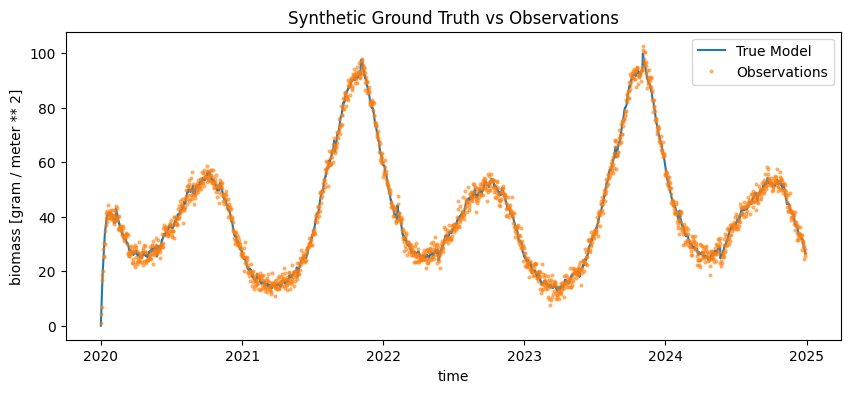

In [12]:
config_generator = NoTransportConfigurationGenerator()

true_energy = 0.1668
true_tr = 10.38

lambda_temperature_0 = 1 / 150
gamma_lambda_temperature = 0.15
gamma_tr = -0.11


true_fg = NoTransportFunctionalGroup(
    day_layer=0,
    night_layer=0,
    energy_transfert=true_energy,
    lambda_temperature_0=lambda_temperature_0,
    gamma_lambda_temperature=gamma_lambda_temperature,
    tr_0=true_tr,
    gamma_tr=gamma_tr,
    name="Zooplankton",
)

true_config = config_generator.generate(
    functional_group_parameters=[true_fg], forcing_parameters=forcing_param, kernel=None
)

with NoTransportModel.from_configuration(configuration=true_config) as model:
    model.run()
    # Extract biomass sum
    true_biomass = model.state["biomass"].sum("functional_group")

# Prepare noisy observation
noise = np.random.normal(0, 0.05 * np.mean(true_biomass), size=true_biomass.shape)
obs_data = (true_biomass + noise).expand_dims({"Z": [0]})
obs_data.name = "biomass_obs"

# Create Observation object
observation = TimeSeriesObservation(name="synthetic_survey", observation=obs_data, observation_type=DayCycle.DAY)

# Visualize
plt.figure(figsize=(10, 4))
true_biomass.plot(label="True Model")
obs_data.plot(linestyle="None", marker="o", markersize=2, label="Observations", alpha=0.5)
plt.legend()
plt.title("Synthetic Ground Truth vs Observations")
plt.show()

## 3. Configuration for Optimization

We define the same functional group but replace the "unknown" values with `Parameter` objects containing initial guesses and bounds.


In [13]:
optim_fg = NoTransportFunctionalGroup(
    day_layer=0,
    night_layer=0,
    energy_transfert=Parameter(
        lower_bound=0.001, upper_bound=0.5, name="energy_transfert", init_method=random_uniform_exclusive
    ),
    lambda_temperature_0=lambda_temperature_0,
    gamma_lambda_temperature=gamma_lambda_temperature,
    tr_0=Parameter(lower_bound=0.0001, upper_bound=100, name="tr_0", init_method=random_uniform_exclusive),
    gamma_tr=gamma_tr,
    name="Zooplankton",
)

cost_func = CostFunction(
    configuration_generator=config_generator,
    functional_groups=FunctionalGroupSet([optim_fg]),
    forcing=forcing_param,
    kernel=None,
    observations=[observation],
    processor=TimeSeriesScoreProcessor(comparator=rmse_comparator),
)

ga_params = GeneticAlgorithmParameters(POP_SIZE=30, NGEN=10, CXPB=0.9, MUTPB=1, INDPB=1 / 2, ETA=20.0)

## 4. Run Optimization

We execute the genetic algorithm sequentially.


In [14]:
ga = GeneticAlgorithmFactory.create_sequential(meta_parameter=ga_params, cost_function=cost_func)

print("Starting optimization...")
results = ga.optimize()
print("Optimization complete.")

Starting optimization...
Optimization complete.


## 5. Analyze Results


In [15]:
# Find the best individual (minimum weighted fitness)
best_idx = results[(LogbookCategory.WEIGHTED_FITNESS, LogbookCategory.WEIGHTED_FITNESS)].idxmax()
best_individual = results.loc[best_idx]

# Extract parameter values
best_params = best_individual[LogbookCategory.PARAMETER]
print("Best individual parameters:")
print(best_params)
print(
    f"\nBest fitness (RMSE): {best_individual[(LogbookCategory.WEIGHTED_FITNESS, LogbookCategory.WEIGHTED_FITNESS)]:.6f}"
)

Best individual parameters:
name
energy_transfert     0.165965
tr_0                10.503550
Name: (7, False, 27), dtype: float64

Best fitness (RMSE): -2.207025


In [16]:
# Create functional group with optimized parameters
optimized_fg = NoTransportFunctionalGroup(
    name="Zooplankton",
    day_layer=0,
    night_layer=0,
    energy_transfert=best_params["energy_transfert"],
    gamma_tr=gamma_tr,
    tr_0=best_params["tr_0"],
    gamma_lambda_temperature=gamma_lambda_temperature,
    lambda_temperature_0=lambda_temperature_0,
)

# Generate configuration with optimized parameters
optimized_config = config_generator.generate(
    functional_group_parameters=[optimized_fg],
    forcing_parameters=forcing_param,
)

# Run model with optimized parameters
with NoTransportModel.from_configuration(optimized_config) as optimized_model:
    optimized_model.run()
    optimized_biomass = optimized_model.state.biomass

optimized_biomass = (
    optimized_biomass.expand_dims({"layer": [0]}).isel(functional_group=0).drop_vars(["functional_group"])
)

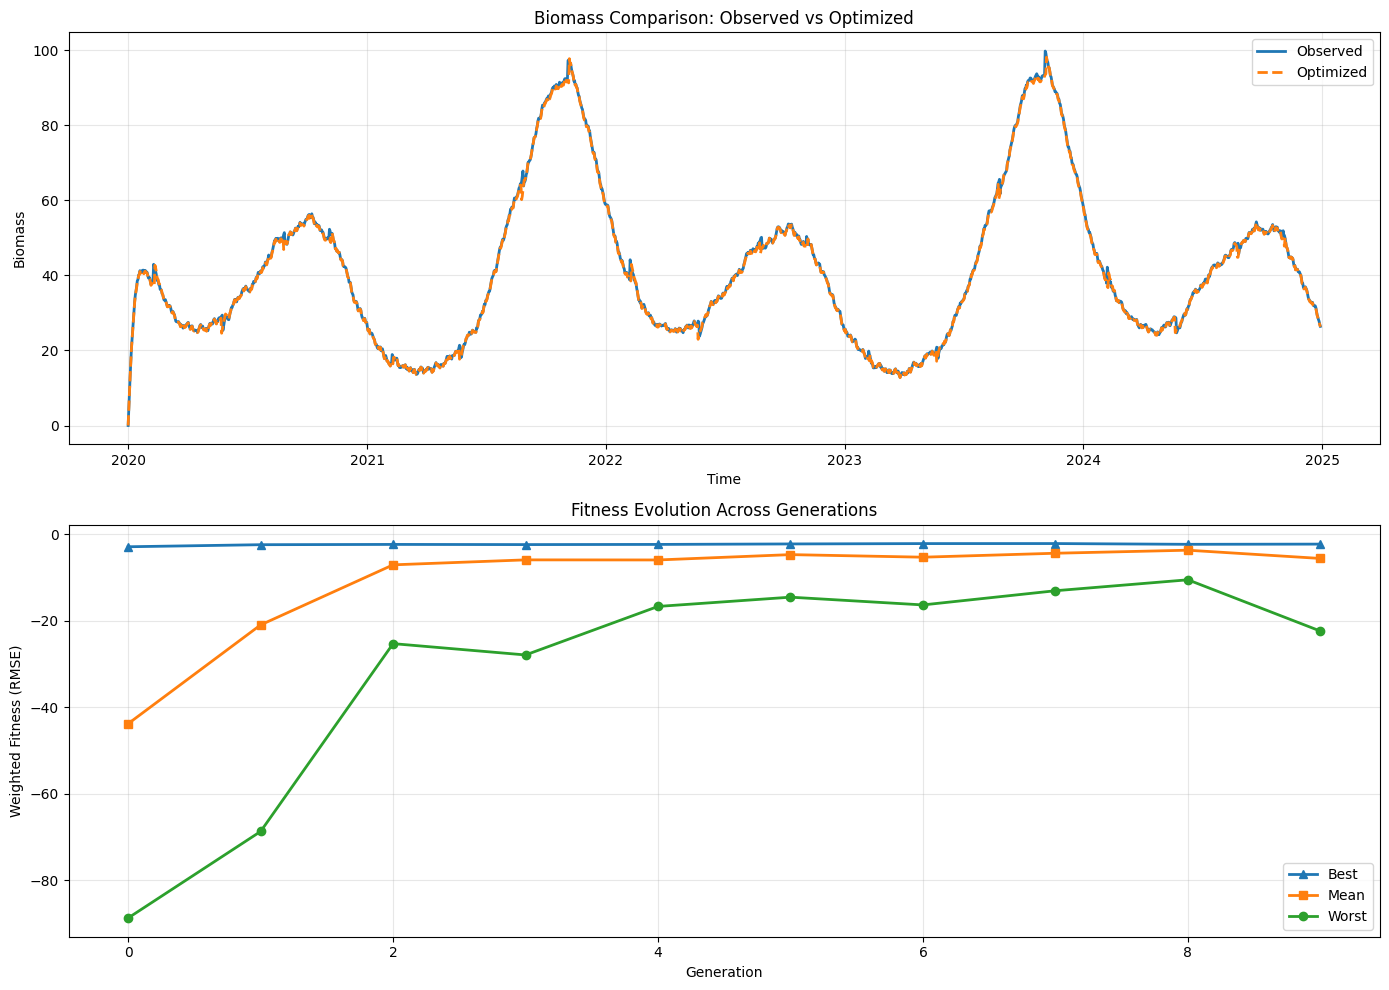


Final RMSE: -2.207025


In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot biomass comparison
true_biomass.plot(ax=ax1, label="Observed", linewidth=2)
optimized_biomass.plot(ax=ax1, label="Optimized", linestyle="--", linewidth=2)
ax1.set_title("Biomass Comparison: Observed vs Optimized")
ax1.set_xlabel("Time")
ax1.set_ylabel("Biomass")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot fitness evolution
fitness_evolution = (
    results[LogbookCategory.WEIGHTED_FITNESS].groupby(LogbookIndex.GENERATION).agg(["min", "mean", "max"])
)

fitness_evolution["Weighted_fitness"]["max"].plot(ax=ax2, label="Best", marker="^", linewidth=2)
fitness_evolution["Weighted_fitness"]["mean"].plot(ax=ax2, label="Mean", marker="s", linewidth=2)
fitness_evolution["Weighted_fitness"]["min"].plot(ax=ax2, label="Worst", marker="o", linewidth=2)
ax2.set_title("Fitness Evolution Across Generations")
ax2.set_xlabel("Generation")
ax2.set_ylabel("Weighted Fitness (RMSE)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal RMSE: {best_individual[(LogbookCategory.WEIGHTED_FITNESS, LogbookCategory.WEIGHTED_FITNESS)]:.6f}")